# Text Summarization with attention mechanism

In [324]:
import pandas as pd
import numpy as np
import re  # regular expression
import warnings
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Embedding,
    Dense,
    Concatenate,
    TimeDistributed,
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [325]:
!git clone https://github.com/thushv89/attention_keras.git


fatal: destination path 'attention_keras' already exists and is not an empty directory.


In [326]:
import os
import sys

base_dir = os.path.join(
    os.getcwd(),
    "./attention_keras",
)
sys.path.insert(0, base_dir)

from tensorflow.keras import Input, layers, models
from attention_keras.src.layers.attention import AttentionLayer

attn_layer = AttentionLayer(name="attention_layer")

In [327]:
data = pd.read_csv(
    "../Dataset//amazon_reviews/Reviews.csv",
    usecols=["Summary", "Text"],
    nrows=50000,
)
data.head()
data.info(
    verbose=True,
)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Summary  49998 non-null  object
 1   Text     50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## Explonatory data analysis and data preparation

We need to remove all duplicate sentences from the dataset.\
Remove and NA values from the dataset.

```python

In [328]:
data.drop_duplicates(subset=["Text"], inplace=True)  # drop duplicates
data.dropna(inplace=True)  # drop na values

data.info(
    verbose=True,
)

data.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 46253 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Summary  46253 non-null  object
 1   Text     46253 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [329]:
data.tail()


,Summary,Text
49995,Grown to really like them,My sister introduced me to these. They have be...
49996,Healthy Snack at a great price!,A friend recommended these bars and I fell in ...
49997,Raw Revolution Hazelnut Cashew,Fabulous! I take one to work with me every da...
49998,"fantastic, but chew carefully",I love these bars and will continue to buy the...
49999,Very Tasty and Healthy.,"These are very good; nutritious, great flavor ..."


#### Some words will be in its short form, which will not be recognized by algorithm. 
#### We will now replace these words by their exact form

In [330]:
contraction_mapping = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "this's": "this is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "here's": "here is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}


# copied from stackoverflow


### We will use NLTK library stopwords to remove stopwords from the dataset

In [331]:
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to /home/jeel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Text Cleaner will remove all punctuations and special characters from the dataset because they are not useful for our algorithm to process the data and will reduce the accuracy of the algorithm


In [332]:
stop_words = set(stopwords.words("english"))


def text_cleaner(text, num):
    newString = text.lower()  # Convert everything to lowercase
    newString = re.sub("<[^<]+?>", "", newString)  # Remove HTML tags
    newString = re.sub(r"\([^)]*\)", "", newString)  # Remove parenthesis
    newString = re.sub('"', "", newString)  # Remove quotes
    newString = " ".join(
        [
            contraction_mapping[t] if t in contraction_mapping else t
            for t in newString.split(" ")
        ]
    )  # Contraction mapping
    newString = re.sub(r"'s\b", "", newString)  # Remove all 's
    newString = re.sub(
        "[^a-zA-Z]", " ", newString
    )  # remove all character except letters
    newString = re.sub("[m]{2,}", "mm", newString)  # remove all m's
    if num == 0:
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens = newString.split()
    long_words = []
    for i in tokens:
        if len(i) > 1:  # removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()


# using stackoverflow and regex documentation to clean the data


##### cleaning the dataset and removing stopwords from "Text" column



In [333]:
cleaned_text = []
for t in data["Text"]:
    cleaned_text.append(text_cleaner(t, 0))


- ##### cleaning the dataset and removing stopwords from "Summary" column



In [334]:
cleaned_summary = []
for t in data["Summary"]:
    cleaned_summary.append(text_cleaner(t, 1))


- ##### overview of the cleaned dataset

In [335]:
cleaned_text[:5]


['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [336]:
cleaned_summary[:5]


['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

- #### Create new Columns for cleaned "Text" and "Summary"



In [337]:
data["cleaned_text"] = cleaned_text
data["cleaned_summary"] = cleaned_summary


In [338]:
# drop empty rows

data.replace("", np.nan, inplace=True)
data.dropna(axis=0, inplace=True)


- ### let's do some visualization of the data

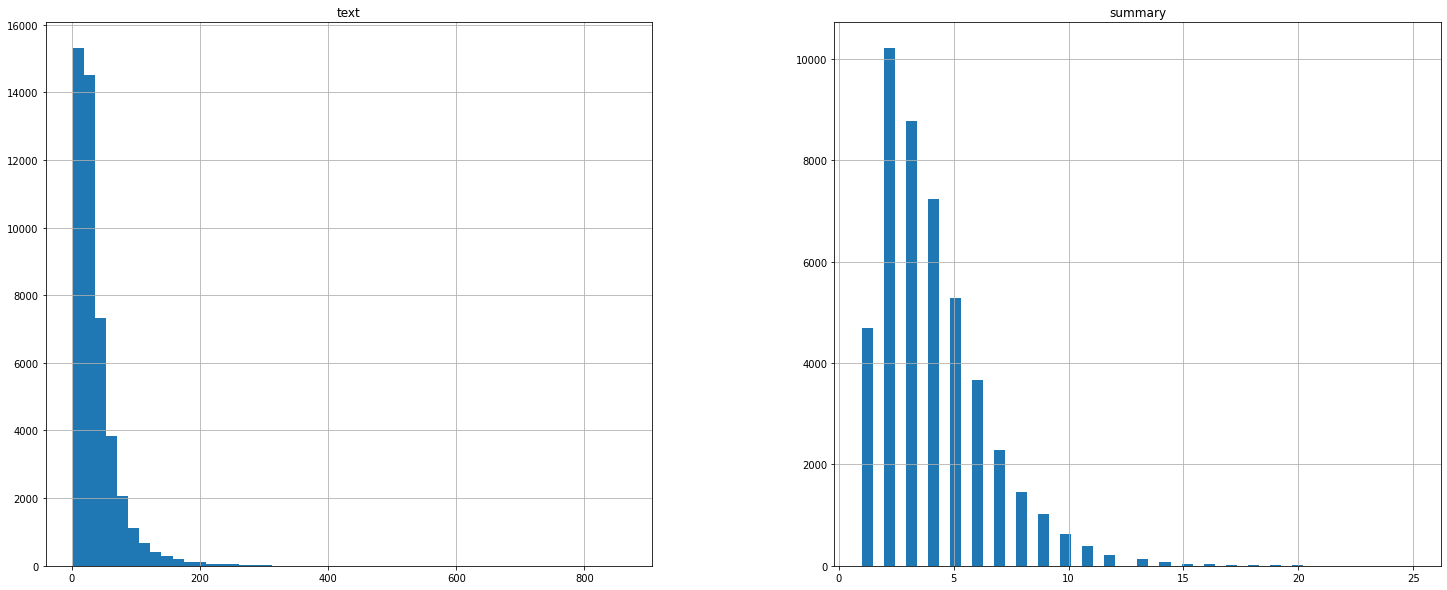

In [339]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data["cleaned_text"]:
    text_word_count.append(len(i.split()))

for i in data["cleaned_summary"]:
    summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({"text": text_word_count, "summary": summary_word_count})

length_df.hist(bins=50, figsize=(25, 10))

plt.show()


- ##### Since majority of summary have maximum length 13 and majority of text have maximum length 30, we will fix these values as max length parameters

In [340]:
max_text_len = 100 # max sentence length in the text
max_summary_len = 13 # max sentence length in the summary


In [341]:
cleaned_text = np.array(data["cleaned_text"])
cleaned_summary = np.array(data["cleaned_summary"])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if (
        len(cleaned_summary[i].split()) <= max_summary_len
        and len(cleaned_text[i].split()) <= max_text_len
    ):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df = pd.DataFrame({"text": short_text, "summary": short_summary})

df


,text,summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy
...,...,...
43731,sister introduced become favorite carry around...,grown to really like them
43732,friend recommended bars fell love great price ...,healthy snack at great price
43733,fabulous take one work every day feel deprived...,raw revolution hazelnut cashew
43734,love bars continue buy beware occasionally con...,fantastic but chew carefully



- Add **START** and *END* token as **sos(start of sentence)** and **eos(end of sentence)** respectively

In [342]:
df["summary"] = df["summary"].apply(lambda x: "sos " + x + " eos")
df

,text,summary
0,bought several vitality canned dog food produc...,sos good quality dog food eos
1,product arrived labeled jumbo salted peanuts p...,sos not as advertised eos
2,confection around centuries light pillowy citr...,sos delight says it all eos
3,looking secret ingredient robitussin believe f...,sos cough medicine eos
4,great taffy great price wide assortment yummy ...,sos great taffy eos
...,...,...
43731,sister introduced become favorite carry around...,sos grown to really like them eos
43732,friend recommended bars fell love great price ...,sos healthy snack at great price eos
43733,fabulous take one work every day feel deprived...,sos raw revolution hazelnut cashew eos
43734,love bars continue buy beware occasionally con...,sos fantastic but chew carefully eos


##### perform test and train split using sklearn library

In [343]:
from sklearn.model_selection import train_test_split

# use 10% data for testing
x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(df["text"]),
    np.array(df["summary"]),
    test_size=0.1,
    random_state=42,  # seed
    shuffle=True, # shuffle the data
)

#### tokenizer will be used to convert the text into tokens and then we will use the tokens to create word embedding

In [344]:
# prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [345]:
thresh = 4

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    tot_freq = tot_freq + value
    if value < thresh:
        cnt = cnt + 1
        freq = freq + value

print("% of rare words in vocabulary:", (cnt / tot_cnt) * 100)
print("Total Coverage of rare words:", (freq / tot_freq) * 100)

% of rare words in vocabulary: 63.75669615049209
Total Coverage of rare words: 2.2735272802567557


In [349]:
# prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt - cnt)
x_tokenizer.fit_on_texts(list(x_tr))

# convert text sequences into integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# padding zero upto maximum length
x_tr = pad_sequences(x_tr_seq, maxlen=max_text_len, padding="post")
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding="post")

# size of vocabulary ( +1 for padding token)
x_voc = x_tokenizer.num_words + 1



AttributeError: 'numpy.ndarray' object has no attribute 'lower'

#### pickle the tokenizer for future use

In [347]:
import pickle

with open("tokenizer.pkl", "wb") as fout:
    pickle.dump(x_tokenizer, fout)

In [296]:
x_voc

4345

In [297]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))


In [298]:
thresh = 6

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    tot_freq = tot_freq + value
    if value < thresh:
        cnt = cnt + 1
        freq = freq + value

print("% of rare words in vocabulary:", (cnt / tot_cnt) * 100)
print("Total Coverage of rare words:", (freq / tot_freq) * 100)

% of rare words in vocabulary: 81.45032962036827
Total Coverage of rare words: 9.820116875061212


In [299]:
# prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt - cnt)
y_tokenizer.fit_on_texts(list(y_tr))

# convert text sequences into integer sequences
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)

# padding zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding="post")
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding="post")

# size of vocabulary
y_voc = y_tokenizer.num_words + 1

In [300]:
y_tokenizer.word_counts["sos"], len(y_tr)

(11693, 11693)

In [301]:
ind = []
for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [302]:
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

In [303]:
from tensorflow.python.keras import backend as K
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
# attention_result = AdditiveAttention(use_scale=True)([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)




In [304]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 100)      434500      ['input_36[0][0]']               
                                                                                                  
 lstm (LSTM)                    [(None, 30, 300),    481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [305]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")


In [306]:
# usinf Earlystop to get the control over training and validation loss

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2)


In [308]:
# Training the model

history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=128,
    validation_data=(
        [x_val, y_val[:, :-1]],
        y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:],
    ),
)


Epoch 1/50
88/88 [==============================] - 87s 991ms/step - loss: 1.9510 - val_loss: 2.0268
Epoch 2/50
88/88 [==============================] - 89s 1s/step - loss: 1.9002 - val_loss: 2.0166
Epoch 3/50
88/88 [==============================] - 85s 961ms/step - loss: 1.8541 - val_loss: 1.9939
Epoch 4/50
88/88 [==============================] - 84s 959ms/step - loss: 1.8088 - val_loss: 1.9792
Epoch 5/50
88/88 [==============================] - 86s 975ms/step - loss: 1.7660 - val_loss: 1.9808
Epoch 6/50
88/88 [==============================] - 86s 973ms/step - loss: 1.7292 - val_loss: 1.9817
Epoch 6: early stopping


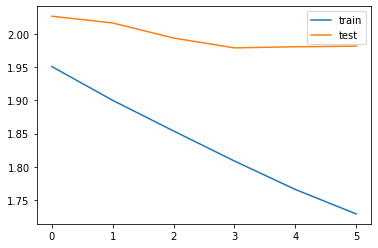

In [309]:
# Understand the behavior of the model

from matplotlib import pyplot

pyplot.plot(history.history["loss"], label="train")
pyplot.plot(history.history["val_loss"], label="test")
pyplot.legend()
pyplot.show()


In [310]:
model.save("Summarization_model.h5")


In [311]:
# Buiöd the dictionary to convert the index into word for traget and source vocabulary

reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index


In [312]:
# Encode the input sequence to get the feature vector
encoder_model = Model(
    inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c]
)


In [313]:
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))


In [314]:
# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c]
)


In [315]:
# attention inference
attn_out_inf, attn_states_inf = attn_layer(
    [decoder_hidden_state_input, decoder_outputs2]
)
decoder_inf_concat = Concatenate(axis=-1, name="concat")(
    [decoder_outputs2, attn_out_inf]
)


In [316]:
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)


In [317]:
# Final decoder model
decoder_model = Model(
    [decoder_inputs]
    + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2],
)


In [318]:
encoder_model.save("encoder_model.h5")
decoder_model.save("decoder_model.h5")


In [319]:
# function for the implementation of the inference process


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index["sos"]

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != "eos":
            decoded_sentence += " " + sampled_token

        # Exit condition: either hit max length or find stop word.
        if sampled_token == "eos" or len(decoded_sentence.split()) >= (
            max_summary_len - 1
        ):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


In [320]:
# convert an integer sequence to a word sequence for summary as well as the reviews


def seq2summary(input_seq):
    newString = ""
    for i in input_seq:
        if (i != 0 and i != target_word_index["sos"]) and i != target_word_index["eos"]:
            newString = newString + reverse_target_word_index[i] + " "
    return newString


def seq2text(input_seq):
    newString = ""
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + " "
    return newString


In [321]:
# few summaries generated by the model

for i in range(9, 100):
    print("Review:", seq2text(x_tr[i]))
    print("Original summary:", seq2summary(y_tr[i]))
    print("Predicted summary:", decode_sequence(x_tr[i].reshape(1, max_text_len)))
    print("\n")


Review: tea taste wonderful would buy taste alone also purchased wild nature 
Original summary: do not know if the 
1/1 [==============================] - 0s 19ms/step
Predicted summary:  great tea


Review: since getting kuerig coffee maker christmas tries several brands cups love deep aroma taste nantucket blend best right combination medium strong brew blends would rate better coffee shop varieties 
Original summary: great taste and aroma 
1/1 [==============================] - 0s 21ms/step
Predicted summary:  great coffee


Review: tea fine favorite prefer flavored herbal teas tried regular tea unusual flavor like something different 
Original summary: earl grey tea 
1/1 [==============================] - 0s 16ms/step
Predicted summary:  great tea


Review: ordered several times like fairly rich taste without bitterness also smooth one better cups found far 
Original summary: great coffee 
1/1 [==============================] - 0s 17ms/step
Predicted summary:  great coffee


Review